In [129]:
import re
import numpy as np
from numpy.typing import NDArray
from pathlib import Path
import matplotlib.pyplot as plt

V_p_p = 5

get_cutoff = lambda R, C: 1 / (2 * np.pi * R * C)

def read_spec_csv(file_path: Path) -> tuple[list, NDArray, NDArray]:
    """
    Reads the CSV from the Spectrum Analyzer and puts the Metadata in a list, the freq bins and power
    into Numpy Arrays
    """
    # Read the entire CSV file
    with open(file_path, 'r') as f:
        content = f.read()

    # Split content into metadata and data sections using regex to find "DATA"
    parts = re.split(r'\bDATA\b', content)
    
    # Check if "DATA" section was found
    if len(parts) != 2:
        raise ValueError("No DATA section found in the file.")

    metadata_section = parts[0].strip()  # Everything before DATA
    data_section = parts[1].strip()      # Everything after DATA

    # Parse the metadata section
    metadata = {}
    for line in metadata_section.splitlines():
        if ',' in line:
            key, value = line.split(',', 1)
            metadata[key.strip()] = value.strip()

    # Parse the data section (split by newline, then split by comma)
    data = []
    for line in data_section.splitlines():
        if ',' in line:
            try:
                x, y = map(float, line.split(','))
                data.append([x, y])
            except ValueError:
                print(f"Skipping invalid line: {line}")
    
    # Convert data into numpy arrays
    data = np.array(data)
    frequencies = data[:, 0]  # First column (Frequency)
    values = data[:, 1]       # Second column (Values)

    return metadata, frequencies, values

def sort_by_first(l1: list, l2: list):
    """
    Sorts two lists in ascending order based on the first list.
    """
    combined = sorted(zip(l1, l2))
    sorted_list1, sorted_list2 = zip(*combined)
    return list(sorted_list1), list(sorted_list2)

def scientific_2_str(value: float, unit: str = "Ω") -> str:
    prefixes = [
        (1e9, 'G'),
        (1e6, 'M'),
        (1e3, 'k'),
        (1, ''),
        (1e-3, 'm'),
        (1e-6, 'µ'),
        (1e-9, 'n'),
        (1e-12, 'p')
    ]

    for factor, prefix in prefixes:
        if abs(value) >= factor:
            formatted = value / factor
            return f"{formatted:.3g} {prefix}{unit}"
    return f"{value:.3g} {unit}"  # fallback for very small values

def plot_pll_ranges(f_c: float, f_f_min: float, f_f_max: float,
                    f_H_min: float, f_H_max: float,
                    title: str = "PLL Frequency Ranges"):

    plt.figure(figsize=(10, 2))

    plt.axvline(f_c, color='red', linestyle='--', label=f"Cutoff freq = {f_c/1e3:.1f} kHz")

    plt.hlines(1, f_f_min, f_f_max, colors='blue', linewidth=6, label="Pull-In Range")

    plt.hlines(2, f_H_min, f_H_max, colors='green', linewidth=6, label="Hold-In Range")

    plt.yticks([1, 2], ["Pull-In", "Hold-In"])
    plt.xlabel("Frequency [Hz]")
    plt.title(title)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_compare(x1: NDArray, y1: NDArray,
                 x2: NDArray, y2: NDArray,
                 title: str,
                 x_label: str="Resistance [Ohm]",
                 y_label: str="Frequency [Hz]",
                 x_log: bool=False,
                 y_log: bool=False,
                 label1: str="Measurement 1",
                 label2: str="Measurement 2",
                 marker1: str='o',
                 marker2: str='s'):
    """
    Plots two datasets (x1, y1) and (x2, y2) on the same plot.
    This function assumes that x1 and x2 are frequency bins and y1 and y2 are the corresponding power bins.
    """
    
    # Align the bins to their corresponding measurements
    plt.figure(figsize=(8, 4))

    # Check if data requires log scaling
    if x_log and y_log:
        plt.loglog(x1, y1, marker=marker1, label=label1)
        plt.loglog(x2, y2, marker=marker2, label=label2)
    elif x_log:
        plt.semilogx(x1, y1, marker=marker1, label=label1)
        plt.semilogx(x2, y2, marker=marker2, label=label2)
    elif y_log:
        plt.semilogy(x1, y1, marker=marker1, label=label1)
        plt.semilogy(x2, y2, marker=marker2, label=label2)
    else:
        plt.plot(x1, y1, marker=marker1, label=label1)
        plt.plot(x2, y2, marker=marker2, label=label2)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot(x: NDArray, 
             y: NDArray,
             title: str,
             x_label: str="Resistance [Ohm]",
             y_label: str="Frequency [Hz]",
             x_log: bool=False,
             y_log: bool=False,
             marker: str='o'):

    plt.figure(figsize=(8, 4))

    if x_log and y_log:
        plt.loglog(x, y, marker=marker)
    elif x_log:
        plt.semilogx(x, y, marker=marker)
    elif y_log:
        plt.semilogy(x, y, marker=marker)
    else:
        plt.plot(x, y, marker=marker)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


For f_min GND at VCO_1,IN

### Task 3.1.1

Our observation were:
- that the minimum frequency stays constant across the $R_1$ range.
- but $R_2$ and $C_1$ have an effect to the minimum frequency. Bigger values reduce the minimum frequency.

3.1.1.1 a)

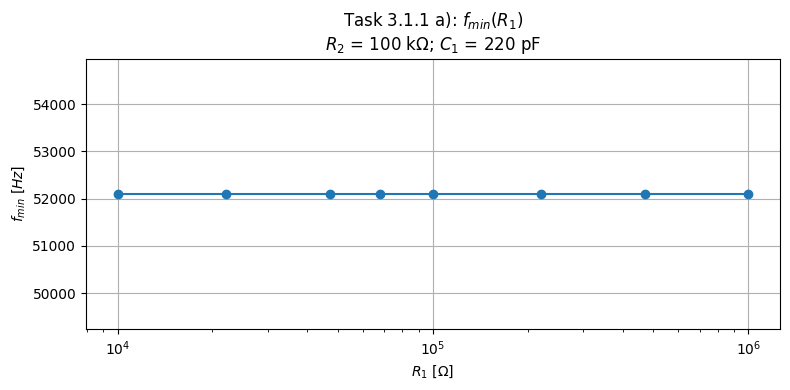

In [130]:
R_2 = 100e3
C_1 = 220e-12

R_1   = [22e3,   10e3,   47e3,   68e3,   100e3,  220e3,  470e3,  1e6]
f_min = [52.1e3, 52.1e3, 52.1e3, 52.1e3, 52.1e3, 52.1e3, 52.1e3, 52.1e3]

R_1, f_min  = sort_by_first(R_1, f_min)

title: str = (r"Task 3.1.1 a): $f_{min}(R_1)$" + 
            f"\n$R_2$ = {scientific_2_str(R_2)}; $C_1$ = {scientific_2_str(C_1, "F")}")
plot(R_1, f_min, title, x_log=True, y_label=r"$f_{min}$ $[Hz]$", x_label=r"$R_1$ $[\Omega]$")

3.1.1.1 b)

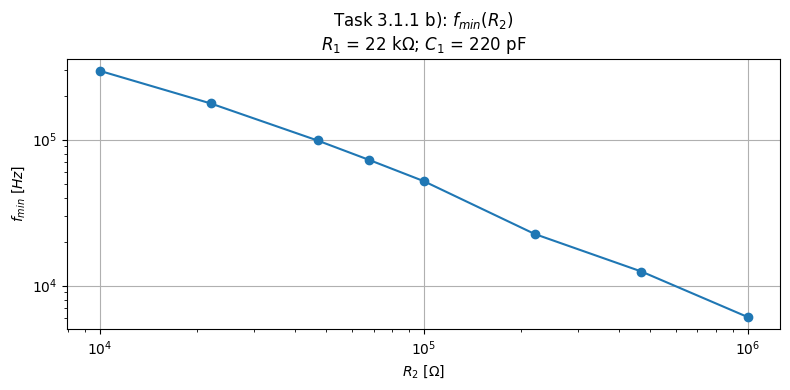

In [131]:
V_p_p = 5
R_1 = 22e3
C_1 = 220e-12

R_2   = [10e3,  22e3,  47e3,   68e3,   100e3, 220e3,  470e3,  1e6]
f_min = [296e3, 177e3, 98.7e3, 72.5e3, 52e3,  22.6e3, 12.5e3, 6.1e3]

title = (r"Task 3.1.1 b): $f_{min}(R_2)$" +
          f"\n$R_1$ = {scientific_2_str(R_1)}; $C_1$ = {scientific_2_str(C_1, "F")}")
plot(R_2, f_min, title, y_log=True, x_log=True, y_label=r"$f_{min}$ $[Hz]$", x_label=r"$R_2$ $[\Omega]$")

3.1.1.1 c)

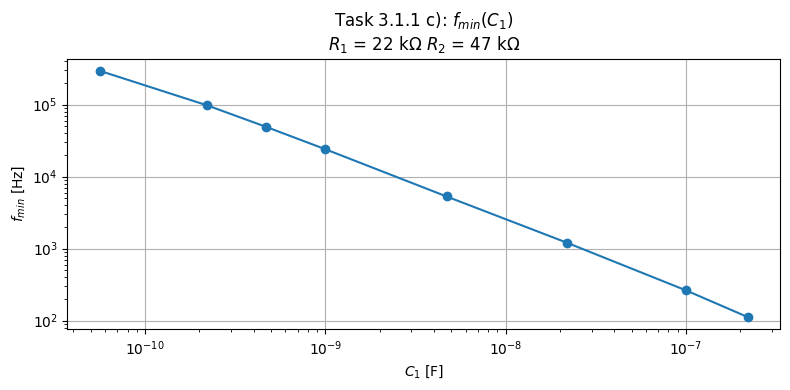

In [132]:
V_p_p = 5
R_1 = 22e3
R_2 = 47e3

C_1 =   [56e-12, 220e-12, 470e-12, 1e-9, 4.7e-9, 22e-9, 100e-9, 220e-9]
f_min = [295e3,  98e3,    49e3,    24e3, 5.3e3,  1.2e3, 263   , 112]

title = (r"Task 3.1.1 c): $f_{min}(C_1)$"+
         f"\n$R_1$ = {scientific_2_str(R_1)} $R_2$ = {scientific_2_str(R_2)}")
plot(C_1, f_min, title, x_log=True, y_log=True, x_label=r"$C_1$ [F]", y_label=r"$f_{min}$ [Hz]")


### 3.1.1.2

We observe that with a higher $R_1$ value the maximum frequency is decresing.

For f_max on VCO_1_IN

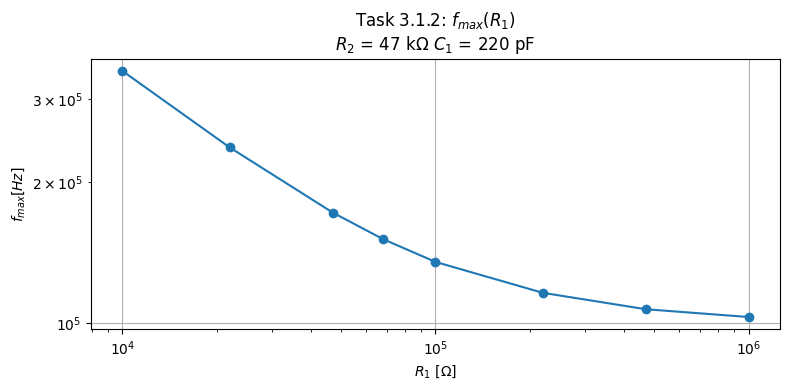

In [133]:
R_2 = 47e3
C_1 = 220e-12

R_1 =   [22e3,  10e3,  47e3,  68e3,  100e3, 220e3, 470e3, 1e6]
f_max = [237e3, 345e3, 172e3, 151e3, 135e3, 116e3, 107e3, 103e3]

R_1, f_max = sort_by_first(R_1, f_max)

title = (r"Task 3.1.2: $f_{max}(R_1$)"+
         f"\n$R_2$ = {scientific_2_str(R_2)} $C_1$ = {scientific_2_str(C_1, "F")}")
plot(R_1, f_max, title,
     y_log=True, x_log=True,
     y_label=r"$f_{max} [Hz]$",
     x_label=r"$R_1$ $[\Omega]$")

### 3.1.3.3: Would you have expected the behavior from 1. and 2. above? Why? <br> Please elaborate including potential references to the applicable datasheet figures

We are using this datasheet as our reference: [HEF4046BT datasheet](https://assets.nexperia.com/documents/data-sheet/HEF4046B.pdf) <br>
This result can be expected as we can see in Fig. 7 in the datasheet, where a increased $R_2$ value reduces the $f_{min}$, aswell as a smaller $C_1$ value. <br>
But also Fig. 8 shows us a smaller ratio of $\frac{f_{max}}{f_{min}}$ at an increased $\frac{R_2}{R_1}$ ratio.

### 3.1.2. Characteristic curve of the VCO

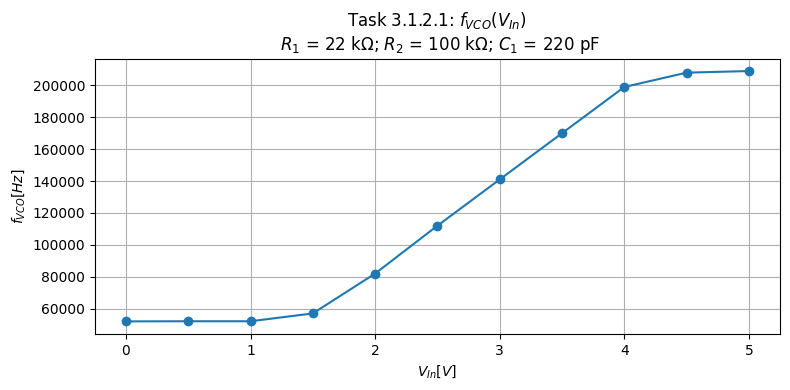

In [134]:
R_1 = 22e3
R_2 = 100e3
C_1 = 220e-12

V_in =  [0,     0.5,    1,      1.5,  2,    2.5,   3,     3.5,   4.0,   4.5,   5]
f_vco = [52.e3, 52.1e3, 52.1e3, 57e3, 82e3, 112e3, 141e3, 170e3, 199e3, 208e3, 209e3]

title = ("Task 3.1.2.1: $f_{VCO}(V_{In})$" +
        f"\n $R_1$ = {scientific_2_str(R_1)}; $R_2$ = {scientific_2_str(R_2)}; $C_1$ = {scientific_2_str(C_1, "F")}")
plot(V_in, f_vco, title, x_label="$V_{In} [V]$", y_label="$f_{VCO} [Hz]$")

3.1.2.2

The significance of the saturation frequencies for the hold-in range is, that they limit the maximum/minimum frequencies we can control (in a control system style) the PLL.

3.1.2.3

In our experiment we would expect according to Fig. 8 from the datasheet a ratio of $\frac{f_{max}}{f_{min}} \approx 4 $ at the ratio of $\frac{R_2}{R_1} = \frac{100k\Omega}{22k\Omega} = 4.5455$.
And in our case we achieved a ratio of $\frac{209kHz}{52kHz} = 4$ and therefore we would say that we can agree with the datasheet

### 3.1.3. Hold-in and pull-in range of closed loop PLL

Cutoff Freq: 2842 Hz
Min. Hold Freq.: 55000 Hz
Max. Hold Freq.: 193000 Hz
Min. Pull-In Freq.: 87000 Hz
Max. Pull-In Freq.: 138000 Hz
Pull-In BW: 51 kHz
Hold-In BW: 138 kHz


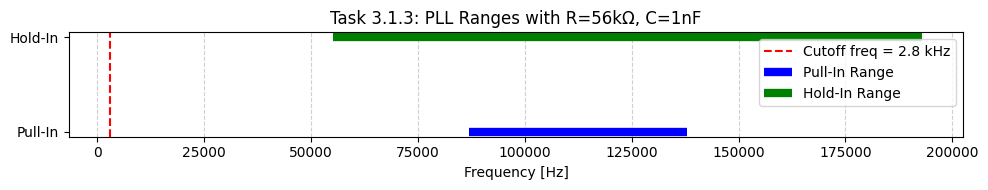

In [135]:
R_f  = 56e3
C_f = 1e-9

f_c = get_cutoff(R_f, C_f)
print(f"Cutoff Freq: {f_c:.0f} Hz")

f_H_min = 55e3
f_H_max = 193e3
f_f_min = 87e3
f_f_max = 138e3

f_H_BW = scientific_2_str(f_H_max - f_H_min, "Hz")
f_f_BW = scientific_2_str(f_f_max - f_f_min, "Hz")

print(f"Min. Hold Freq.: {f_H_min:.0f} Hz")
print(f"Max. Hold Freq.: {f_H_max:.0f} Hz")
print(f"Min. Pull-In Freq.: {f_f_min:.0f} Hz")
print(f"Max. Pull-In Freq.: {f_f_max:.0f} Hz")
print(f"Pull-In BW: {f_f_BW}")
print(f"Hold-In BW: {f_H_BW}")

plot_pll_ranges(
    f_c,
    f_f_min, f_f_max,
    f_H_min, f_H_max,
    title="Task 3.1.3: PLL Ranges with R=56kΩ, C=1nF"
)

3.1.3.2

Cutoff Freq.: 284 Hz
Max. Hold Freq.: 200000 Hz
Min. Hold Freq.: 55000 Hz
Max. Pull-In Freq.: 123000 Hz
Min. Pull-In Freq.: 105000 Hz
Pull-In BW: 18 kHz
Hold-In BW: 145 kHz


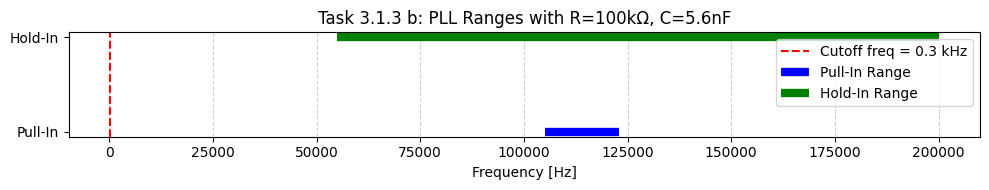

In [ ]:
R_f_max = 100e3
C_f_min = 5.6e-9

f_c_min = get_cutoff(R_f_max, C_f_min)
print(f"Cutoff Freq.: {f_c_min:.0f} Hz")

f_H_max = 200e3
f_H_min = 55e3
f_f_max = 123e3
f_f_min = 105e3

f_H_BW = scientific_2_str(f_H_max - f_H_min, "Hz")
f_f_BW = scientific_2_str(f_f_max - f_f_min, "Hz")

print(f"Max. Hold Freq.: {f_H_max:.0f} Hz")
print(f"Min. Hold Freq.: {f_H_min:.0f} Hz")
print(f"Max. Pull-In Freq.: {f_f_max:.0f} Hz")
print(f"Min. Pull-In Freq.: {f_f_min:.0f} Hz")
print(f"Pull-In BW: {f_f_BW}")
print(f"Hold-In BW: {f_H_BW}")

plot_pll_ranges(f_c_min, f_f_min, f_f_max, f_H_min, f_H_max,
                title="Task 3.1.3 b: PLL Ranges with R=100kΩ, C=5.6nF")

3.1.3.3

Cutoff Freq.: 28421 Hz
Max. Pull-In Freq.: 200000 Hz
Min. Pull-In Freq.: 56000 Hz
Pull-In BW: 144 kHz
Min. Hold Freq.: 55000 Hz
Max. Hold Freq.: 200000 Hz
Hold-In BW: 145 kHz


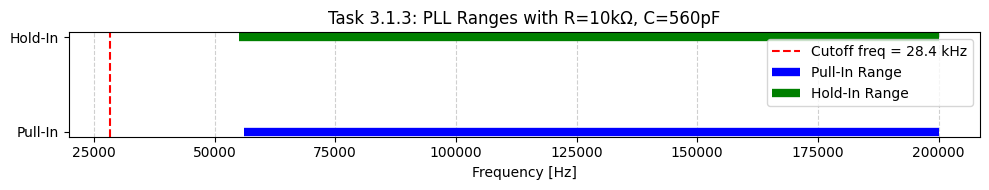

In [137]:
R_f_min = 10e3
C_f_min = 560e-12

f_c_max = get_cutoff(R_f_min, C_f_min)
print(f"Cutoff Freq.: {f_c_max:.0f} Hz")

f_H_max = 200e3
f_f_max = 200e3
f_H_min = 55e3
f_f_min = 56e3

f_H_BW = scientific_2_str(f_H_max - f_H_min, "Hz")
f_f_BW = scientific_2_str(f_f_max - f_f_min, "Hz")

print(f"Max. Pull-In Freq.: {f_f_max:.0f} Hz")
print(f"Min. Pull-In Freq.: {f_f_min:.0f} Hz")
print(f"Pull-In BW: {f_f_BW}")

print(f"Min. Hold Freq.: {f_H_min:.0f} Hz")
print(f"Max. Hold Freq.: {f_H_max:.0f} Hz")
print(f"Hold-In BW: {f_H_BW}")


plot_pll_ranges(
    f_c_max,
    f_f_min, f_f_max,
    f_H_min, f_H_max,
    title="Task 3.1.3: PLL Ranges with R=10kΩ, C=560pF"
)

3.1.3.4

We can observe, that with a higher cutoff frequency the the hold-in frequency and pull-in frequency are the same. <br>
With a very low cutoff frequency the hold-in range is a bit reduced compared to the very high cutoff frequency, but not by much compared to the $2.8kHz$ meassurement. <br>
However the pull in range is mostly affected by the change of the cutoff frequency and its bandwidth is greatly reduced by lower cutoff frequencies.

 ### 3.1.3.5

Expected cut-off freq. : 8.84 kHz
Max. Pull-In Freq.: 158000 Hz
Min. Pull-In Freq.: 67000 Hz
Min. Hold Freq.: 55000 Hz
Max. Hold Freq.: 200000 Hz
Pull-In BW: 91 kHz
Hold-In BW: 145 kHz


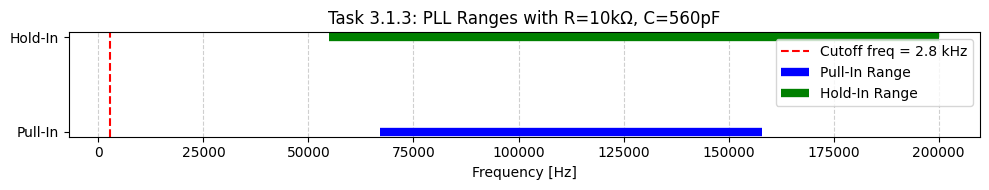

In [148]:
R_f = 10e3
C_f = 1.8e-9

fc = get_cutoff(R_f, C_f)

print(f"Expected cut-off freq. : {scientific_2_str(fc, "Hz")}")

f_H_max = 200e3
f_f_max = 158e3
f_H_min = 55e3
f_f_min = 67e3

f_H_BW = scientific_2_str(f_H_max - f_H_min, "Hz")
f_f_BW = scientific_2_str(f_f_max - f_f_min, "Hz")

print(f"Max. Pull-In Freq.: {f_f_max:.0f} Hz")
print(f"Min. Pull-In Freq.: {f_f_min:.0f} Hz")
print(f"Min. Hold Freq.: {f_H_min:.0f} Hz")
print(f"Max. Hold Freq.: {f_H_max:.0f} Hz")
print(f"Pull-In BW: {f_f_BW}")
print(f"Hold-In BW: {f_H_BW}")

plot_pll_ranges(
    f_c,
    f_f_min, f_f_max,
    f_H_min, f_H_max,
    title="Task 3.1.3: PLL Ranges with R=10kΩ, C=560pF"
)

### 3.2.2 a) Phase noise measurement

### CSV-File Overview

| File Number | Filename               | Description                                       |
|-------------|------------------------|---------------------------------------------------|
| 0           | `Ampcor_0000.csv`      | Internal reference                                |
| 1           | `Ampcor_0001.csv`      | Charge Pump I = 0.625 mA                 |
| 2           | `Ampcor_0002.csv`      | Charge Pump I = 2.5 mA                   |
| 3           | `Ampcor_0003.csv`      | Charge Pump I = = 5 mA                     |
| 4           | `Ampcor_0004.csv`      | External reference (no shift) – 10 MHz           |
| 5           | `Ampcor_0005.csv`      | External reference (no shift) – 50 MHz           |
| 6           | `Ampcor_0006.csv`      | External reference (no shift) – 100 MHz          |
| 7           | `Ampcor_0007.csv`      | External reference with frequency shift – 10 MHz |
| 8           | `Ampcor_0008.csv`      | External reference with frequency shift – 50 MHz |
| 9           | `Ampcor_0009.csv`      | External reference with frequency shift – 100 MHz |



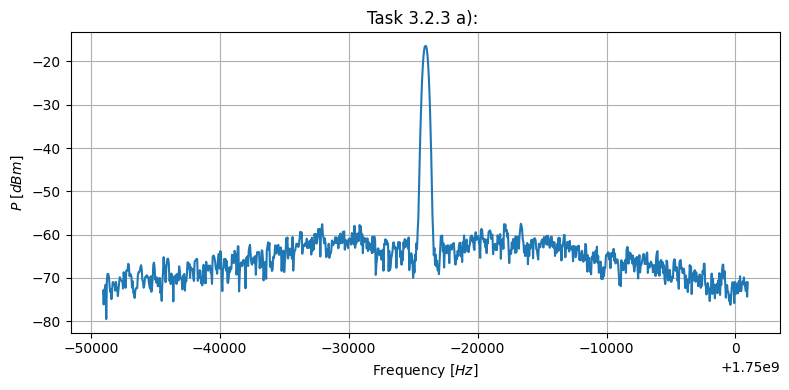

In [ ]:
RBW = 1e3
VBW = 30
span = 50e3

freq_offset = [1e3, 2e3, 5e3, 10e3, 25e3]

meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0000.csv")

title = "Task 3.2.3 a): "
plot(freq_bins, pwr_bins, title, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

### 3.2.2 b) Variation of the charge pump current

We observed an higher noise floor based on a higher shot noise.

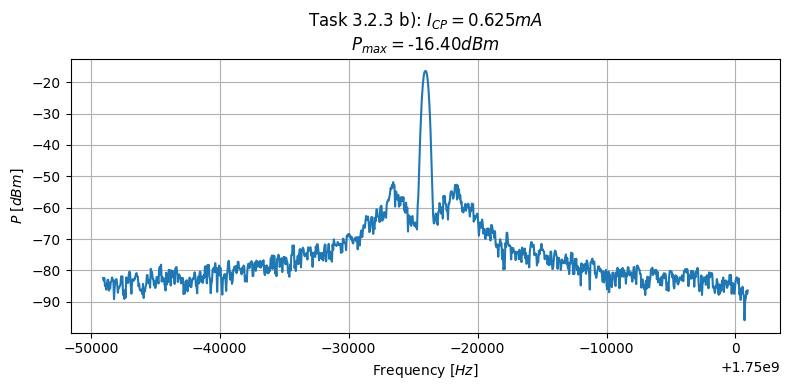

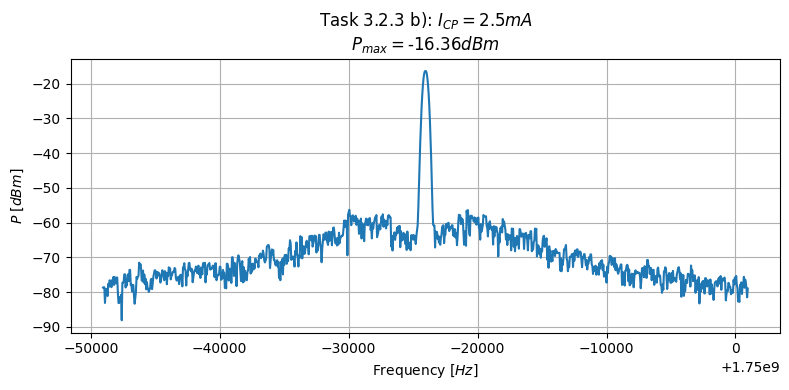

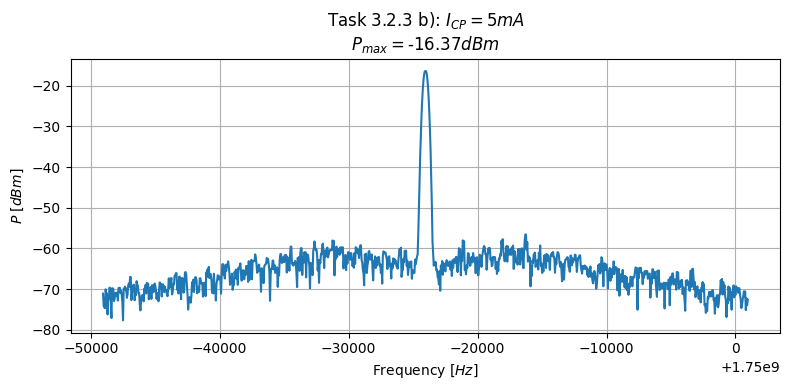

In [140]:
meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0001.csv")
max_pwr = max(pwr_bins)
title = r"Task 3.2.3 b): $I_{CP} = 0.625mA$" + f"\n" + r"$P_{max}=$" + f"{max_pwr:.2f}" + r"$dBm$"
plot(freq_bins, pwr_bins, title, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0002.csv")
max_pwr = max(pwr_bins)
title = r"Task 3.2.3 b): $I_{CP} = 2.5mA$" + f"\n" + r"$P_{max}=$" + f"{max_pwr:.2f}" + r"$dBm$"
plot(freq_bins, pwr_bins, title, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0003.csv")
max_pwr = max(pwr_bins)
title = r"Task 3.2.3 b): $I_{CP} = 5mA$" + f"\n" + r"$P_{max}=$" + f"{max_pwr:.2f}" + r"$dBm$"
plot(freq_bins, pwr_bins, title, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

### 3.2.3 a) External reference source and source divider function

Comparison: <br>
We expect that the external waveform generator creates a worse signal than the interal signal generator.
The reason being that the waveform generator itself probably uses a PLL to create its functions and like already mentioned in the introduction chapter of the document, a PLL is less stable than a crystal oscillator, but on the other hand tunable to a broader frequency band. <br>
Our spectrum shows this behaviour. <br>
We indeed can inspect a higher noise floor than with the internal clock and a lower peak power with the external one. <br>
Sadly somehow our spectrum has a offset on the frequency/x-axis, which was not present at the time of meassuring. Therefore we do that addition to rectify this.

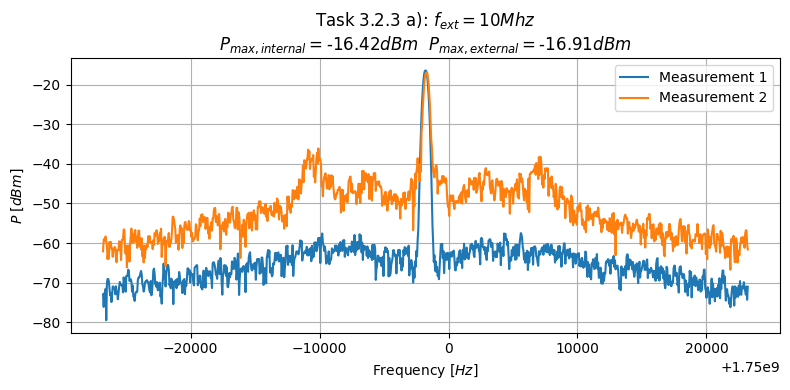

In [141]:
meta_data1, freq_bins1, pwr_bins1 = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0000.csv")
meta_data2, freq_bins2, pwr_bins2 = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0007.csv")

# so to offset our recording mistake we correct offset the bins
freq_bins1 = np.add(freq_bins1, freq_bins2[0] - freq_bins1[0])

max_pwr1 = max(pwr_bins1)
max_pwr2 = max(pwr_bins2)
title = r"Task 3.2.3 a): $f_{ext} = 10Mhz$" + f"\n" + r"$P_{max,internal}=$" + f"{max_pwr1:.2f}" + r"$dBm$" + f"\t" + r"$P_{max,external}=$" + f"{max_pwr2:.2f}" + r"$dBm$"

plot_compare(
    freq_bins1, pwr_bins1, 
    freq_bins2, pwr_bins2,
    title,
    x_label="Frequency $[Hz]$",
    y_label=r"$P$ $[dBm]$",
    marker1="None",  # No markers for the first data set
    marker2="None"   # No markers for the second data set
)


### 3.2.3 b) External reference source and source divider function

With a increased reference frequency, we can observe a reduction of the phase noise. This could be a result, that within a smaller period, thus a higher frequency, the PLL can react in a smaller time frame to phase noise and adjust itself.

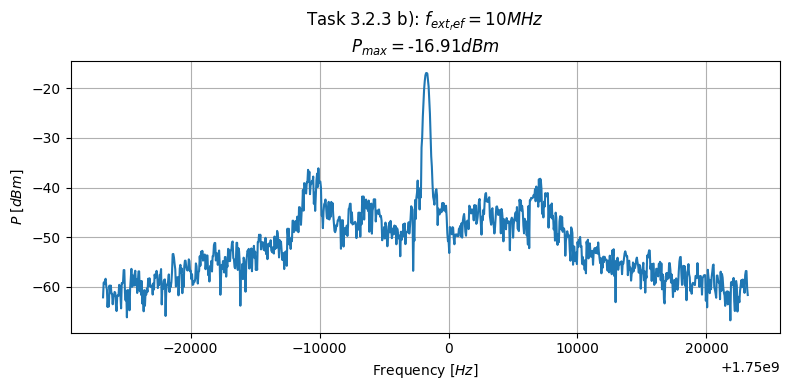

In [142]:
meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0007.csv")
max_pwr = max(pwr_bins)
title = r"Task 3.2.3 b): $f_{ext_ref} = 10MHz$" + f"\n" + r"$P_{max}=$" + f"{max_pwr:.2f}" + r"$dBm$"
plot(freq_bins, pwr_bins, title, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

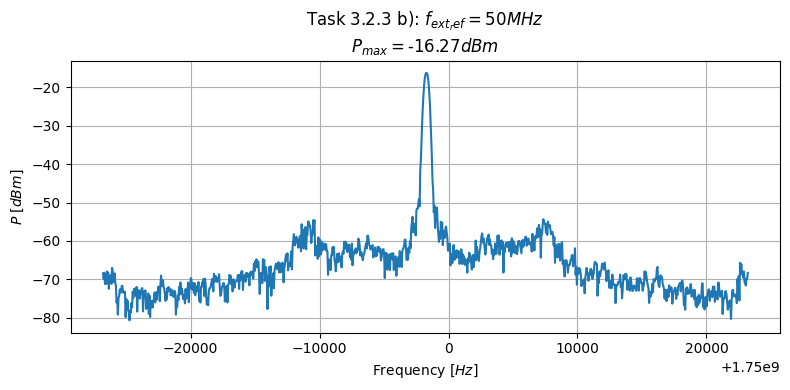

In [143]:
meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0008.csv")
max_pwr = max(pwr_bins)
title = r"Task 3.2.3 b): $f_{ext_ref} = 50MHz$" + f"\n" + r"$P_{max}=$" + f"{max_pwr:.2f}" + r"$dBm$"
plot(freq_bins, pwr_bins, title, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

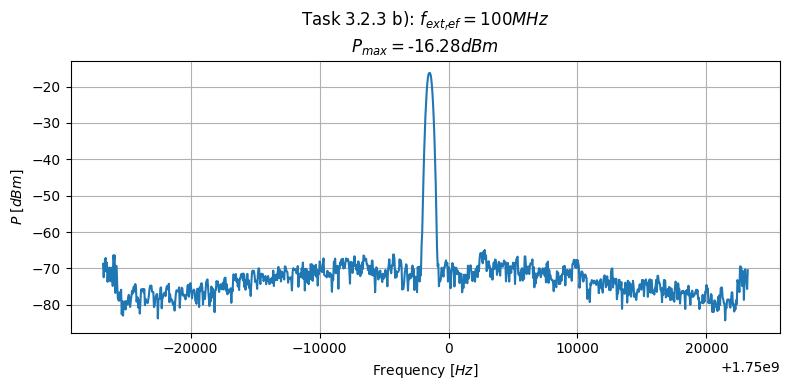

In [144]:
meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements_Spectrum_Analyzer/Ampcor_0009.csv")
max_pwr = max(pwr_bins)
title = r"Task 3.2.3 b): $f_{ext_ref} = 100MHz$" + f"\n" + r"$P_{max}=$" + f"{max_pwr:.2f}" + r"$dBm$"
plot(freq_bins, pwr_bins, title, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")